In [1]:
import os
import glob

import numpy as np
from matplotlib import pyplot as plt

In [2]:
# These lines of code are setting various parameters for the appearance of plots created using the matplotlib library. 
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size = 20)
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams['xtick.major.width']  = 1
plt.rcParams['ytick.major.width']  = 1
plt.rcParams['xtick.major.pad']= 8

In [3]:
tracer = 'LRG'
region = 'NScomb' # choices=['NGC', 'SGC', 'NS', 'S', 'NGCS', 'SGCS', 'NScomb']
theory_name = 'bao'
clustering_statistics = 'pk' # choices=['pk', 'xi']
on_the_fly_GaussianCovariance_matrix = '' # choices=['on_the_fly_GaussianCovariance_matrix', '']
zmin, zmax, b0 = {'LRG': (0.4, 1.1, 1.7), 'ELG': (1.1, 1.6, 0.84), 'QSO': (1.6, 2.1, 1.2)}[tracer]

In [4]:
base_dir = '/global/cfs/cdirs/desi/users/uendert/blinding/' #'/global/homes/u/uendert/desi-y1-kp45/blinding' #'..'
profiles_fn = sorted(glob.glob(os.path.join(base_dir, 'blinded', 'test_w0-*', '{}'.format(on_the_fly_GaussianCovariance_matrix), '{}'.format(theory_name), '{}'.format(clustering_statistics), 'profile_{}_{}_{}_{}.npy'.format(tracer, region, zmin, zmax))))
profiles_unblinded_fn = os.path.join(base_dir, 'unblinded','{}'.format(on_the_fly_GaussianCovariance_matrix), '{}'.format(theory_name), '{}'.format(clustering_statistics),'profile_{}_{}_{}_{}.npy'.format(tracer, region, zmin, zmax))

In [5]:
from desilike.samples import Profiles

profiles = Profiles.load(profiles_unblinded_fn)

In [6]:
bestfit = {name: [] for name in ['qpar', 'qper', 'chi2min']}
error = {name: [] for name in ['qpar', 'qper']}
expected = {name: [] for name in ['qpar', 'qper']}
expected_unblided = {}


from desilike.samples import Profiles
profiles_unblinded = Profiles.load(profiles_unblinded_fn)
index = profiles_unblinded.bestfit.logposterior.argmax()

bestfit_unblinded = {name: profiles_unblinded.bestfit[name][index] for name in error}
bestfit_unblinded['qiso'] = bestfit_unblinded['qpar']**(1./3.) * bestfit_unblinded['qper']**(2./3.)
bestfit_unblinded['chi2min'] = profiles_unblinded.bestfit.chi2min
# bestfit_unblinded['chi2min_red'] = float(profiles.bestfit.chi2min / profiles.bestfit.attrs['ndof'])
error_unblinded = {name: profiles_unblinded.error[name][index] for name in error}
for name in error_unblinded: error_unblinded[name] = error_unblinded[name]
                   
expected_unblided['qpar'] = profiles_unblinded.attrs['expected']['qpar']
expected_unblided['qper'] = profiles_unblinded.attrs['expected']['qper']

cov_unblinded = profiles_unblinded.covariance.view(params=['qper', 'qpar'])
jac = np.array([2.0 / 3.0, 1.0 / 3.0])
qiso_error_unblinded = {'qiso': jac.dot(cov_unblinded).dot(jac)**0.5}

qiso_error = []

for profiles_fn_ in profiles_fn:
    profiles = Profiles.load(profiles_fn_)
    for name in expected: expected[name].append(profiles.attrs['expected'][name])
    index = profiles.bestfit.logposterior.argmax()
    for name in error: bestfit[name].append(profiles.bestfit[name][index])
    for name in error: error[name].append(profiles.error[name][index])
    cov = profiles.covariance.view(params=['qper', 'qpar'])
    jac = np.array([2.0 / 3.0, 1.0 / 3.0])
    qiso_error.append(jac.dot(cov).dot(jac)**0.5)    
    bestfit['chi2min'].append(profiles.bestfit.chi2min)


bestfit['qiso'] = list(np.array(bestfit['qpar'])**(1./3.) * np.array(bestfit['qper'])**(2./3.))
expected['qiso'] = list(np.array(expected['qpar'])**(1./3.) * np.array(expected['qper'])**(2./3.))
error['qiso'] = qiso_error
expected_unblided['qiso'] = expected_unblided['qpar']**(1./3.) * expected_unblided['qper']**(2./3.)


error_unblinded['qiso'] = qiso_error_unblinded['qiso']

In [7]:
error

{'qpar': [0.020200343277522737,
  0.011863055975680437,
  0.018573076036426772,
  0.019827649981584372,
  0.01908031890896278,
  0.012388234504902007,
  0.01194477923836662,
  0.01265291636551924],
 'qper': [0.01187240852319199,
  0.009343641543940073,
  0.011402462156981985,
  0.011553602078956449,
  0.012090096556854668,
  0.009503883737444208,
  0.008852817748993158,
  0.008967797945103773],
 'qiso': [0.008158097462468906,
  0.006425055668336434,
  0.007606639790046851,
  0.007948282111645739,
  0.006533129097544685,
  0.008001162226366695,
  0.006193155177063669,
  0.006334283948223363]}

In [8]:
import pandas as pd

In [9]:
df_error_unblinded = pd.DataFrame(error_unblinded, index=[0])
df_error_unblinded.rename(columns={"qpar": "qpar_err", "qper": "qper_err", "qiso": "qiso_err"}, inplace=True)
df_error = pd.DataFrame(error)
df_error.rename(columns={"qpar": "qpar_err", "qper": "qper_err", "qiso": "qiso_err"}, inplace=True)

In [10]:
df_error_unblinded

,qpar_err,qper_err,qiso_err
0,0.018945,0.011798,0.007901


In [11]:
df_error

,qpar_err,qper_err,qiso_err
0,0.020200,0.011872,0.008158
1,0.011863,0.009344,0.006425
2,0.018573,0.011402,0.007607
3,0.019828,0.011554,0.007948
4,0.019080,0.012090,0.006533
5,0.012388,0.009504,0.008001
6,0.011945,0.008853,0.006193
7,0.012653,0.008968,0.006334


In [12]:
unblinded_cosmo = {'w0': -1.0, 'wa': 0.0, 'f': 0.8}
unblinded_cosmo.update(bestfit_unblinded)
unblinded_cosmo.update({'ndof': profiles_unblinded.bestfit.attrs['ndof']})
cosmo_unblinded = pd.DataFrame(unblinded_cosmo, index=[0])
cosmo_unblinded = pd.concat([cosmo_unblinded, df_error_unblinded], axis=1)
cosmo_unblinded

,w0,wa,f,qpar,qper,qiso,chi2min,ndof,qpar_err,qper_err,qiso_err
0,-1.0,0.0,0.8,1.021843,0.985518,0.997481,138.155344,97,0.018945,0.011798,0.007901


In [13]:
base = '/global/cfs/cdirs/desi/survey/catalogs/main/mocks/FirstGenMocks/AbacusSummit/Y1/mock1/LSScats/'
data_dir = base + 'blinded/jmena/test_w0-*/LSScats/blinded/'
fn_list = sorted(glob.glob(os.path.join(data_dir, 'blinded_parameters_{}.csv'.format(tracer))))

cosmo_blinded = {name: [] for name in ['w0', 'wa', 'f']}
ndof = {name: [] for name in ['ndof']}
for j, profiles_fn_ in zip(fn_list, profiles_fn):
    w0_blind, wa_blind, f_blind = np.loadtxt(j, delimiter=',', skiprows=1)
    cosmo_blinded['w0'].append(w0_blind)
    cosmo_blinded['wa'].append(wa_blind)
    cosmo_blinded['f'].append(f_blind)
    ndof['ndof'].append(profiles.bestfit.attrs['ndof'])

cosmo_blinded.update(bestfit)
cosmo_blinded.update(df_error)
cosmo_blinded.update(ndof)
cosmo_blinded = pd.DataFrame(cosmo_blinded)

blinded_concat = pd.concat([cosmo_unblinded, cosmo_blinded ], axis=0)

In [14]:
cosmo_unblinded

,w0,wa,f,qpar,qper,qiso,chi2min,ndof,qpar_err,qper_err,qiso_err
0,-1.0,0.0,0.8,1.021843,0.985518,0.997481,138.155344,97,0.018945,0.011798,0.007901


In [15]:
blinded_concat

,w0,wa,f,qpar,qper,qiso,chi2min,ndof,qpar_err,qper_err,qiso_err
0,-1.000000,0.000000,0.800000,1.021843,0.985518,0.997481,138.155344,97,0.018945,0.011798,0.007901
0,-0.904004,0.025634,0.880000,1.048664,1.003438,1.018292,116.68149566079265,97,0.020200,0.011872,0.008158
1,-0.905703,-0.683114,0.733309,1.008362,0.984435,0.992347,138.5595274252463,97,0.011863,0.009344,0.006425
2,-0.970440,-0.507778,0.720000,1.007869,0.973894,0.985090,137.76857355525556,97,0.018573,0.011402,0.007607
3,-0.996230,0.289309,0.880000,1.041196,0.991341,1.007688,113.1469605327856,97,0.019828,0.011554,0.007948
4,-1.048543,0.140157,0.759545,1.020933,0.979711,0.993263,128.81609179136836,97,0.019080,0.012090,0.006533
5,-1.106392,0.454786,0.764499,1.020874,0.977578,0.991802,140.77279937852077,97,0.012388,0.009504,0.008001
6,-1.161697,0.374612,0.720000,1.006502,0.963849,0.977862,142.9113427535856,97,0.011945,0.008853,0.006193
7,-1.233470,0.765853,0.720000,1.016415,0.956721,0.976219,143.8601382931598,97,0.012653,0.008968,0.006334


In [16]:
df = pd.DataFrame(blinded_concat)
df = df[["w0", "wa", "f", "qpar", "qpar_err", "qper", "qper_err", "qiso", "qiso_err", "chi2min", "ndof"]]

print(df.to_latex(index=False,
                  formatters={"name": str.upper},
                  float_format="{:0.4f}".format, multirow = False))

\begin{tabular}{rrrrrrrrrlr}
\toprule
     w0 &      wa &      f &   qpar &  qpar\_err &   qper &  qper\_err &   qiso &  qiso\_err &            chi2min &  ndof \\
\midrule
-1.0000 &  0.0000 & 0.8000 & 1.0218 &    0.0189 & 0.9855 &    0.0118 & 0.9975 &    0.0079 &           138.1553 &    97 \\
-0.9040 &  0.0256 & 0.8800 & 1.0487 &    0.0202 & 1.0034 &    0.0119 & 1.0183 &    0.0082 & 116.68149566079265 &    97 \\
-0.9057 & -0.6831 & 0.7333 & 1.0084 &    0.0119 & 0.9844 &    0.0093 & 0.9923 &    0.0064 &  138.5595274252463 &    97 \\
-0.9704 & -0.5078 & 0.7200 & 1.0079 &    0.0186 & 0.9739 &    0.0114 & 0.9851 &    0.0076 & 137.76857355525556 &    97 \\
-0.9962 &  0.2893 & 0.8800 & 1.0412 &    0.0198 & 0.9913 &    0.0116 & 1.0077 &    0.0079 &  113.1469605327856 &    97 \\
-1.0485 &  0.1402 & 0.7595 & 1.0209 &    0.0191 & 0.9797 &    0.0121 & 0.9933 &    0.0065 & 128.81609179136836 &    97 \\
-1.1064 &  0.4548 & 0.7645 & 1.0209 &    0.0124 & 0.9776 &    0.0095 & 0.9918 &    0.0080 & 140.

/tmp/ipykernel_11335/3912069840.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False,


In [17]:
print(r'qiso_unblinded = {:.5} \pm {:.5}'.format(bestfit_unblinded['qiso'], qiso_error_unblinded['qiso'] ))

qiso_unblinded = 0.99748 \pm 0.0079005


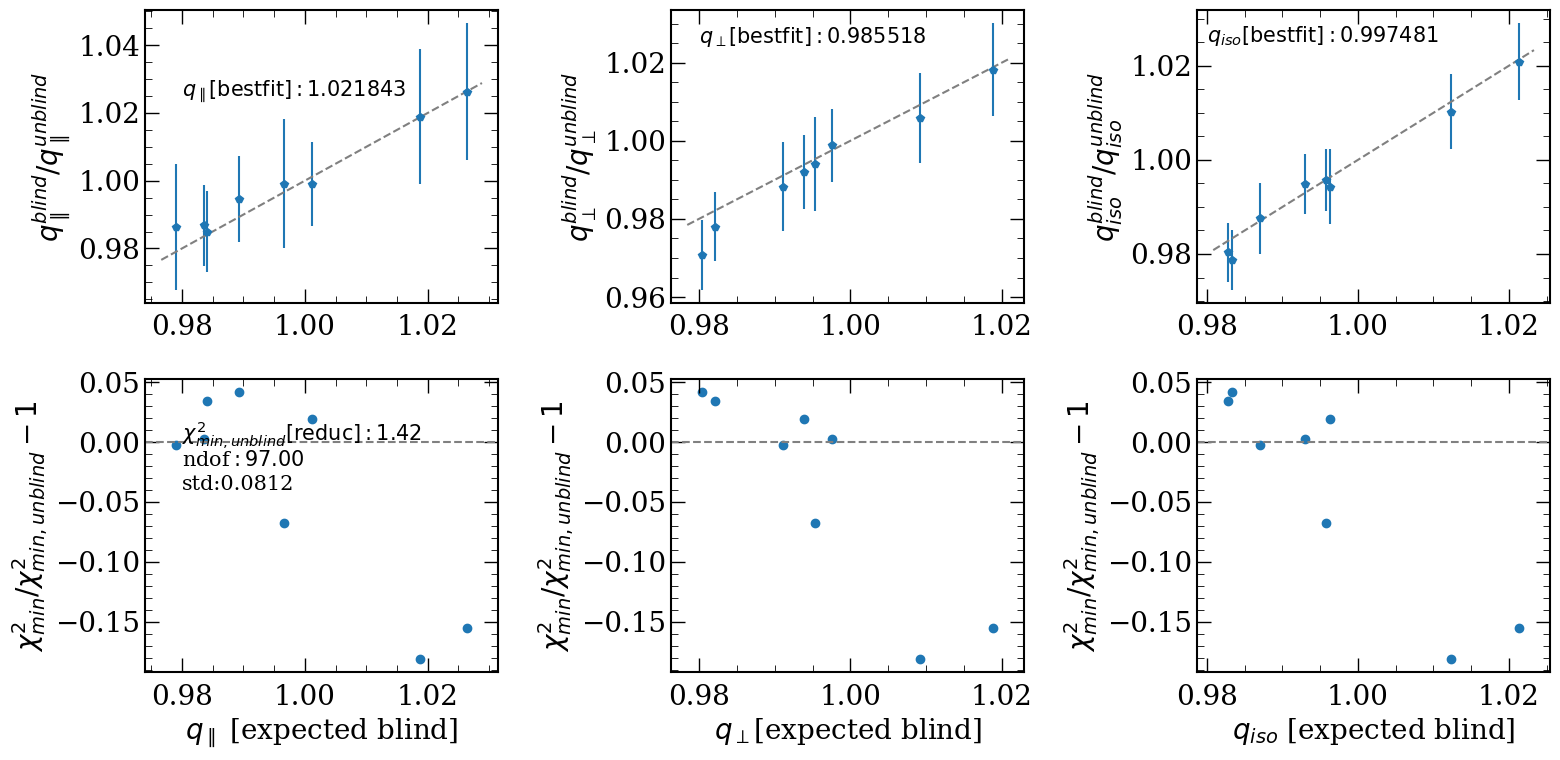

In [18]:
fig, ax = plt.subplots(2, 3, sharex='col')

ax[0, 0].errorbar(expected['qpar'], bestfit['qpar'] / bestfit_unblinded['qpar'], yerr=error['qpar'], fmt='p') #row=0, col=0
ax[0, 0].tick_params('x', labelbottom=True)
ax[0, 0].set(ylabel=r'$q_{\parallel}^{blind} / q_{\parallel}^{unblind}$')
# ax[0, 0].set(xlabel=r'$q_{\parallel}$ [expected blind]', ylabel=r'$q_{\parallel}^{blind} / q_{\parallel}^{unblind}$')
ax[0, 0].plot(ax[0, 0].get_xlim(), ax[0, 0].get_xlim(), c='gray', linestyle='--')
ax[0, 0].text(0.98, 1.025, r'$q_{\parallel}{\rm[bestfit]}: %f$' % (bestfit_unblinded['qpar']), fontsize=15)

ax[1, 0].scatter(expected['qpar'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=0
ax[1, 0].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$q_{\parallel}$ [expected blind]')
ax[1, 0].axhline(y=0., color='gray', linestyle='--')
chi2min_red = profiles_unblinded.bestfit.chi2min / profiles_unblinded.bestfit.attrs['ndof']
if clustering_statistics == 'pk':
    ax[1, 0].text(0.98, 0., r'$\chi^2_{min, unblind}{\rm[reduc]}: %.2f$' % (chi2min_red), fontsize=15)
    chi2min_std = np.array(bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.).std()
    ax[1, 0].text(0.98, -0.04, r'std:{:.3}'.format(chi2min_std), fontsize=15)
    ax[1, 0].text(0.98, -0.02, r'ndof$: %.2f$' % (profiles_unblinded.bestfit.attrs['ndof']), fontsize=15)
else:
    ax[1, 0].text(0.98, 0.2, r'$\chi^2_{min, unblind}{\rm[reduc]}: %.2f$' % (chi2min_red), fontsize=15)
    chi2min_std = np.array(bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.).std()
    ax[1, 0].text(0.98, 0.1, r'std:{:.3}'.format(chi2min_std), fontsize=15)
    ax[1, 0].text(0.98, 0.15, r'ndof$: %.2f$' % (profiles_unblinded.bestfit.attrs['ndof']), fontsize=15)

ax[0, 1].errorbar(expected['qper'], bestfit['qper'] / bestfit_unblinded['qper'], yerr=error['qper'], fmt='p') #row=0, col=1
ax[0, 1].tick_params('x', labelbottom=True)
ax[0, 1].set( ylabel=r'$q_{\perp}^{blind} / q_{\perp}^{unblind}$')
ax[0, 1].plot(ax[0, 1].get_xlim(), ax[0, 1].get_xlim(), c='gray', linestyle='--')
ax[0, 1].text(0.98, 1.025, r'$q_{\perp}{\rm[bestfit]}: %f$' % (bestfit_unblinded['qper']), fontsize=15)

ax[1, 1].scatter(expected['qper'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=1
ax[1, 1].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$q_{\perp}$[expected blind]')
ax[1, 1].axhline(y=0., color='gray', linestyle='--')

ax[0, 2].errorbar(expected['qiso'], bestfit['qiso'] / bestfit_unblinded['qiso'], yerr=error['qiso'], fmt='p') #row=0, col=0
ax[0, 2].tick_params('x', labelbottom=True)
ax[0, 2].set(ylabel=r'$q_{iso}^{blind} / q_{iso}^{unblind}$')
ax[0, 2].plot(ax[0, 2].get_xlim(), ax[0, 2].get_xlim(), c='gray', linestyle='--')
ax[0, 2].text(0.98, 1.025, r'$q_{iso}{\rm[bestfit]}: %f$' % (bestfit_unblinded['qiso']), fontsize=15)

ax[1, 2].scatter(expected['qiso'], bestfit['chi2min'] / bestfit_unblinded['chi2min'] - 1.) #row=1, col=0
ax[1, 2].set(ylabel=r'$\chi^2_{min} / \chi^2_{min, unblind} - 1$', xlabel=r'$q_{iso}$ [expected blind]')
ax[1, 2].axhline(y=0., color='gray', linestyle='--')

# if clustering_statistics == 'pk':
#     fig.suptitle('Covariance generated individually for each blinded cosmology. {}_{}_{}_{}'.format(tracer, region, zmin, zmax), fontsize=18)
# else:
#     fig.suptitle('Same covariance generated with unblinded cosmology. {}_{}_{}_{}'.format(tracer, region, zmin, zmax), fontsize=18)

plt.tight_layout()
# plt.savefig(os.path.join(base_dir, 'blinded', '{}_one2one_plot_{}_{}_{}_{}.png'.format(clustering_statistics, tracer, region, zmin, zmax)))
plt.show()